<a href="https://colab.research.google.com/github/Vinooj/kaggle-competition/blob/main/housing_price_prediction/Ames_Housing_Price_Prediction_Kick_starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research findings on how to tackle this problem: https://docs.google.com/document/d/1cQ9JuvhWk9c-moFPzfNjFl9qOZ5sJeuw74pBhjazHVA

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
# ==============================================================================
# Cell 1: Setup and Imports
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import norm
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
# For stacking
from mlxtend.regressor import StackingCVRegressor

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set some options for pandas and plotting
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# ==============================================================================
# Cell 2: Data Loading and Initial Setup
# ==============================================================================
# Load the datasets
train_df = pd.read_csv('./sample_data/train.csv')
test_df = pd.read_csv('./sample_data/test.csv')

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Save the 'Id' column before splitting and dropping
# original_train_id = train_df['Id']

# Randomly sample 100 rows for the test set and drop them from the training set
# test_set_from_train = train_df.sample(n=100, random_state=42) # Use a random_state for reproducibility
# train_df = train_df.drop(test_set_from_train.index)

Train set shape: (1460, 81)
Test set shape: (1459, 80)


In [ ]:
# Save the 'Id' column for submission and then drop it
train_id = train_df['Id']
test_id = test_df['Id']

# Separate the 'Id' and 'SalePrice' from the new test set. Used to test the model from Train.csv
#test_id = test_set_from_train['Id']
# test_sale_price = test_set_from_train['SalePrice'] # Keep original SalePrice for evaluation

# The 'Id' column is usually not useful for training machine learning models
# as it's just an arbitrary identifier and doesn't contain predictive information.
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)
# test_df = test_set_from_train.drop(['Id', 'SalePrice'], axis=1) # Drop Id and SalePrice from test_df

print(f"Train set shape after splitting: {train_df.shape}")
print(f"Generated Test set shape: {test_df.shape}")
#print(f"Number of test samples generated from train: {len(test_set_from_train)}")
#print("Train IDs dropped. Test IDs and SalePrice for evaluation saved.")

Train set shape after splitting: (1460, 80)
Generated Test set shape: (1459, 79)


In [ ]:
df_num = train_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


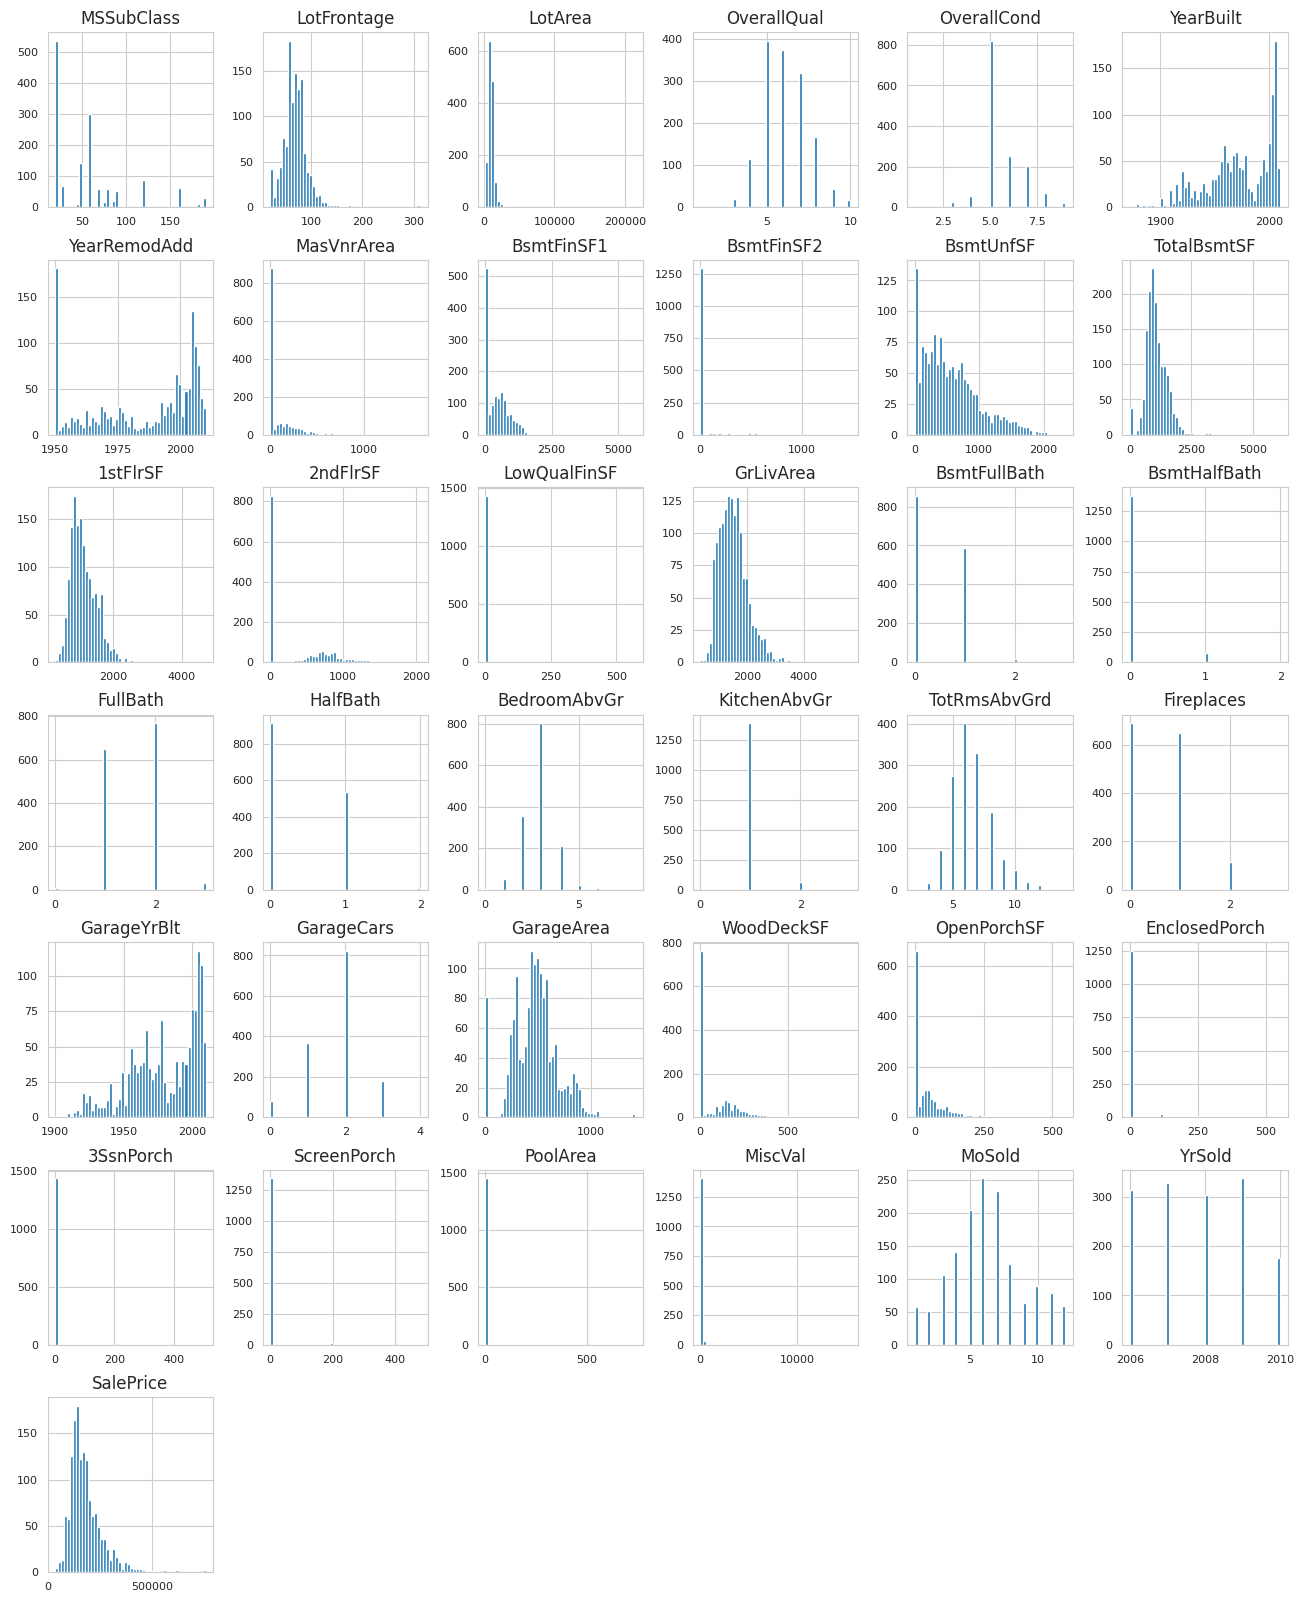

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

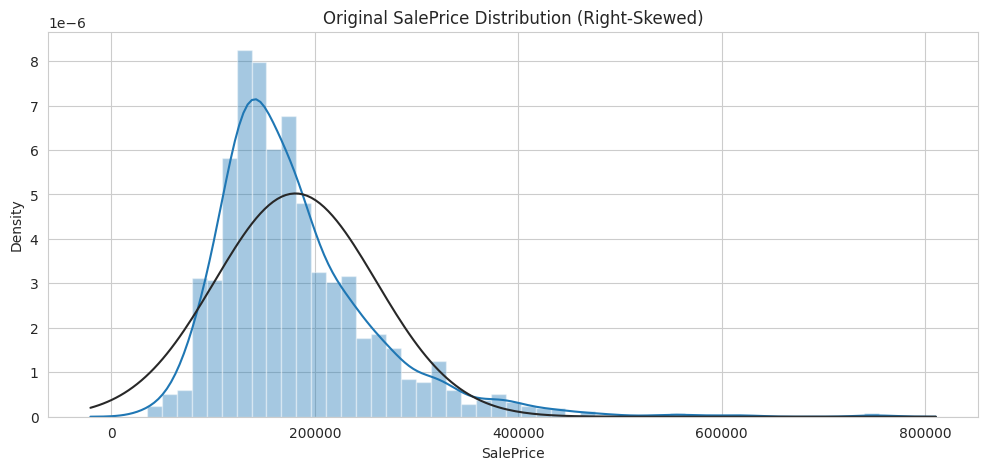

Skewness of original SalePrice: 1.88


In [ ]:
# ==============================================================================
# Cell 3: Section 1 - Data Cleaning and Preparation
# ==============================================================================
# --- Visualizing the original target variable distribution ---
plt.figure(figsize=(12, 5))
sns.distplot(train_df['SalePrice'], fit=norm)
plt.title('Original SalePrice Distribution (Right-Skewed)')
plt.show()
print(f"Skewness of original SalePrice: {train_df['SalePrice'].skew():.2f}")

In [ ]:
# Save the number of training examples for later splitting
n_train = train_df.shape

Visualizing GrLivArea vs SalePrice BEFORE outlier removal...


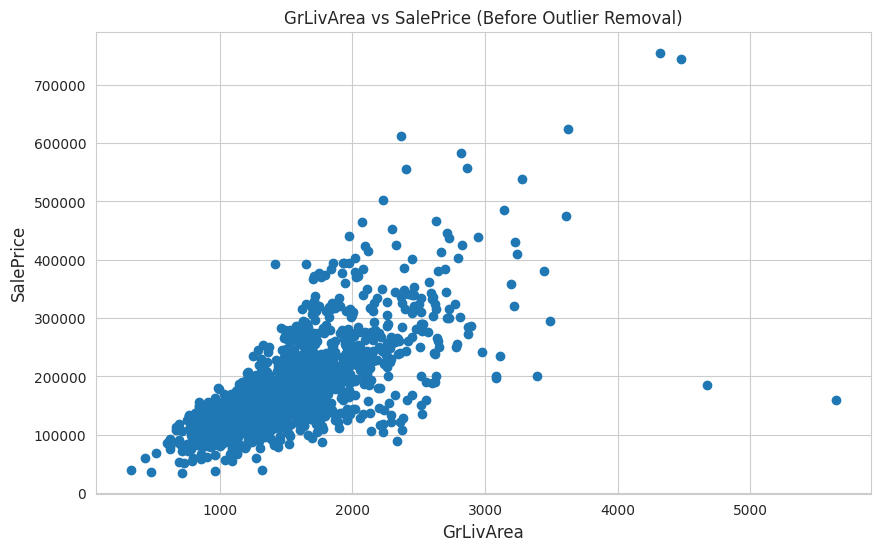

In [ ]:
# Add this code block before outlier removal
# 3.1 Surgical Outlier Handling - Visualization Before Removal
print("Visualizing GrLivArea vs SalePrice BEFORE outlier removal...")
plt.figure(figsize=(10, 6))
plt.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.xlabel("GrLivArea", fontsize=12)
plt.ylabel("SalePrice", fontsize=12)
plt.title("GrLivArea vs SalePrice (Before Outlier Removal)")
plt.show()

Outliers removed. New train set shape: (1456, 80)


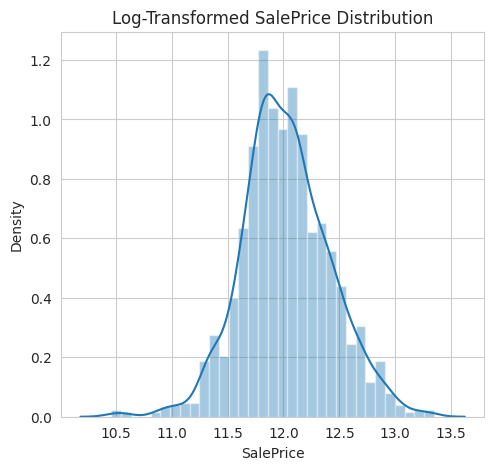

In [ ]:
# 3.1 Surgical Outlier Handling - continued
# As identified in the report, we remove two specific outliers in GrLivArea
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['GrLivArea']<300000)].index)
print(f"Outliers removed. New train set shape: {train_df.shape}")

# 3.2 Target Variable Transformation (Log Transform)
# The competition uses RMSLE, so we log-transform the target variable 'SalePrice'
# We use numpy.log1p which is log(1+x) for numerical stability
y_train = train_df['SalePrice'] # Assign the Series to y_train
y_train = np.log1p(y_train)     # Log-transform the Series

# Visualize the transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.distplot(y_train, fit=None, kde=True)
plt.title('Log-Transformed SalePrice Distribution')
plt.show()

In [ ]:
# Drop SalePrice from the training set and concatenate with test set for unified preprocessing
if 'SalePrice' in train_df.columns :
    train_df.drop('SalePrice', axis=1, inplace=True)

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
print(f"Combined dataset shape: {all_data.shape}")

# --- Strategic Imputation of Missing Data ---
# This follows the detailed imputation strategy from the report.

# Features where NaN means "None" (absence of the feature)
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

# Features where NaN means 0 (absence of the feature leads to zero measurement)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

# Impute LotFrontage with the median of its neighborhood [4, 1, 5, 6, 7]
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# For other miscellaneous missing values, fill with the mode (most frequent value)
for col in ('MSZoning', 'Electrical', 'Utilities', 'Exterior1st', 'Exterior2nd',
            'SaleType', 'KitchenQual'):
    all_data[col] = all_data[col].fillna(all_data[col].mode())

# Functional: data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# Check if any missing values remain
print(f"Remaining missing values: {all_data.isnull().sum().sum()}")

# Find rows with NaN values
rows_with_nan = all_data[all_data.isnull().any(axis=1)]

# Print the result
print(rows_with_nan)

Combined dataset shape: (2915, 79)
Remaining missing values: 11
      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1375          80       RL         73.0     9735   Pave  None      Reg   
1551          50       RL         72.0    10632   Pave  None      IR1   
1911          30      NaN        109.0    21780   Grvl  None      Reg   
1941          20       RL         64.0    31220   Pave  None      IR1   
2147          30       RL         85.0    19550   Pave  None      Reg   
2212          20      NaN         80.0    14584   Pave  None      Reg   
2246          70      NaN         60.0    56600   Pave  None      IR1   
2485          20       RL         85.0    13770   Pave  None      Reg   
2900          20      NaN        125.0    31250   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1375         Lvl    AllPub    Inside       Gtl       Timber       Norm   
1551         Lvl    AllPub    Inside       Gtl      Clear

In [ ]:
# ==============================================================================
# Section 2 - High-Impact Feature Engineering
# ==============================================================================
# This section creates new, more powerful features from the existing ones.

# --- 2.1 Creating Holistic Features from Raw Components ---
# Combine individual space-related features into a single, more powerful 'TotalSF'.
# Assuming Total Bsmt SF, 1st Floor SF, and 2nd Floor SF are the intended features
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Combine all bathroom features into a single 'TotalBaths' feature.
# Assuming Full Bath (above ground), Half Bath (above ground), Bsmt Full Bath, and Bsmt Half Bath
all_data['TotalBaths'] = all_data['FullBath'] + (0.5 * all_data['HalfBath']) + \
                           all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])

# Combine all porch-related features into 'TotalPorchSF'.
# Assuming Open Porch SF, Enclosed Porch, 3Ssn Porch, and Screen Porch
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + \
                             all_data['3SsnPorch'] + all_data['ScreenPorch']

# --- 2.2 Capturing Temporal Dynamics ---
# Create features that represent the age of the house and time since remodeling.
# Assuming YearBuilt and YearRemodAdd
all_data['AgeOfHouse'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']
# Correct any potential data errors where remodel is after sale
all_data.loc[all_data['YearsSinceRemodel'] < 0, 'YearsSinceRemodel'] = 0

# Create a feature indicating if the house was recently remodeled
all_data['IsNewHouse'] = (all_data['YearBuilt'] == all_data['YrSold']).astype(int)

# --- 2.3 Unlocking Non-Linearity with Polynomial and Interaction Features ---
# Create squared terms for the most important features to help linear models capture non-linear relationships.
all_data['OverallQual_sq'] = all_data['OverallQual']**2
all_data['GrLivArea_sq'] = all_data['GrLivArea']**2
# Create an interaction term between Overall Quality and Living Area.
all_data['OverallQual_x_GrLivArea'] = all_data['OverallQual'] * all_data['GrLivArea']

print("Feature engineering complete. New features added.")

Feature engineering complete. New features added.


In [ ]:
# ==============================================================================
# Cell 5: Section 3 - Skewness and Categorical Encoding
# ==============================================================================
# 5.1 Correcting Skewed Numerical Features
numeric_feats = all_data.dtypes[all_data.dtypes!= "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
high_skew = skewness
skewed_features = high_skew.index

for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], 0.15) # Box-Cox transform

print(f"{len(skewed_features)} skewed numerical features transformed.")

# Check to see hwtehr there are NaN
print(f"NaN values in all_data: {all_data.isnull().any(axis=None)}")

# 5.2 Mastering Categorical Variables (One-Hot Encoding)
# The report discusses advanced methods like target encoding. For a robust kick-starter,
# one-hot encoding is a powerful and safe choice.
final_data = pd.get_dummies(all_data).reset_index(drop=True)
print(f"Categorical features one-hot encoded. Final data shape: {final_data.shape}")

# Separate train and test sets again
# Use the number of rows from the processed training data (before concatenation)
# The original n_train stored the shape tuple, which caused the TypeError
n_train_rows = len(train_df) # train_df here is the one *after* outlier removal and dropping 'SalePrice'
X = final_data[:n_train_rows]
X_test = final_data[n_train_rows:]

print(f"Final training features shape: {X.shape}")
print(f"Final test features shape: {X_test.shape}")

# Check to see hwtehr there are NaN
print(X.isnull().any(axis=None))
print(X_test.isnull().any(axis=None))

pd.set_option('display.max_rows', None)
print("\nChecking for missing values per column in all_data:")
print(X_test.isnull().sum())

45 skewed numerical features transformed.
NaN values in all_data: True
Categorical features one-hot encoded. Final data shape: (2915, 310)
Final training features shape: (1456, 310)
Final test features shape: (1459, 310)
False
False

Checking for missing values per column in all_data:
MSSubClass                 0
LotFrontage                0
LotArea                    0
OverallQual                0
OverallCond                0
YearBuilt                  0
YearRemodAdd               0
MasVnrArea                 0
BsmtFinSF1                 0
BsmtFinSF2                 0
BsmtUnfSF                  0
TotalBsmtSF                0
1stFlrSF                   0
2ndFlrSF                   0
LowQualFinSF               0
GrLivArea                  0
BsmtFullBath               0
BsmtHalfBath               0
FullBath                   0
HalfBath                   0
BedroomAbvGr               0
KitchenAbvGr               0
TotRmsAbvGrd               0
Fireplaces                 0
GarageYrBlt       

In [ ]:
# prompt: Can you create the python function to print the scatter plot that accepts a plot title, test_sale_price, ensemble_pred based on the previous cell code

def plot_scatter(plot_title, actual_values, predicted_values):
    """
    Generates and displays a scatter plot comparing actual vs. predicted values.

    Args:
        plot_title (str): The title for the scatter plot.
        actual_values (pd.Series or np.ndarray): The actual values.
        predicted_values (pd.Series or np.ndarray): The predicted values.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    # Add a line representing perfect prediction
    plt.plot([actual_values.min(), actual_values.max()],
             [actual_values.min(), actual_values.max()], 'k--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(plot_title)
    plt.grid(True)
    plt.show()


def print_data(predicted_values):
    output = pd.DataFrame({'Id': test_id,
                       'SalePrice': predicted_values.squeeze()})
    print(output.head())

In [ ]:
# ==============================================================================
# Cell 6: Section 4 & 5 - Modeling (Stacking & Blending)
# ==============================================================================
# Define cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Define rmsle_cv for cross-validation scoring (Note: This function was defined but not explicitly used in the traceback path, keeping it for completeness)
# This function is not causing the error, keeping it as is.
def rmsle_cv(model):
    return np.sqrt(-cross_val_score(model, X.values, y_train.values, scoring="neg_mean_squared_error", cv=kfolds))

# 4.1 Define Base Models
# Using robust hyperparameters found in top public notebooks
# These models will be the Level 0 learners in our stack

# Linear Models (benefit from scaling)
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
elastic_net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ridge = make_pipeline(RobustScaler(), Ridge(alpha=10.0))

# Gradient Boosting Models
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =42)

lgbm = LGBMRegressor(objective='regression',
                       num_leaves=5,
                       learning_rate=0.05, n_estimators=720,
                       max_bin = 55, bagging_fraction = 0.8,
                       bagging_freq = 5, feature_fraction = 0.2319,
                       feature_fraction_seed=9, bagging_seed=9,
                       min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

xgbr = XGBRegressor(learning_rate=0.05, n_estimators=2200,
                     max_depth=3, min_child_weight=0,
                     gamma=0, subsample=0.7,
                     colsample_bytree=0.7,
                     reg_alpha=0.005, nthread=-1,
                     scale_pos_weight=1, seed=27)

# 5.1 Stacking Implementation
# The meta-model will be a regularized linear model (Lasso)
# It learns to combine the predictions of the base models
stacking_reg = StackingCVRegressor(regressors=(ridge, lasso, elastic_net, gbr, xgbr, lgbm),
                                meta_regressor=lasso,
                                use_features_in_secondary=True)

print("Models defined. Ready for training.")

# 5.2 Training and Prediction
print("Training Stacking Regressor...")

# The fit method call itself is correct, the issue is internal to mlxtend's
# call to sklearn.model_selection.cross_val_predict.
stacking_reg.fit(X.values, y_train.values)

stack_pred_log = stacking_reg.predict(X_test.values)
stack_pred = np.expm1(stack_pred_log)
print("Stacking prediction complete.")

print("Training XGBoost for blending...")
xgbr.fit(X, y_train)
xgb_pred_log = xgbr.predict(X_test)
xgb_pred = np.expm1(xgb_pred_log)
print("XGBoost prediction complete.")

print("Training LightGBM for blending...")
lgbm.fit(X, y_train)
lgbm_pred_log = lgbm.predict(X_test)
lgbm_pred = np.expm1(lgbm_pred_log)
print("LightGBM prediction complete.")

# 5.3 Blending
# As a final step, we blend the stacked model's predictions with the best
# individual models' predictions. This often provides a small but crucial boost.
ensemble_pred = (0.70 * stack_pred) + (0.15 * xgb_pred) + (0.15 * lgbm_pred)
print("Ensemble prediction complete.")

Models defined. Ready for training.
Training Stacking Regressor...
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample

In [ ]:
plot_scatter("Actual vs. Ensemble Predicted SalePrice ( Uses all model )", test_sale_price, ensemble_pred)

NameError: name 'plot_scatter' is not defined

In [ ]:
print_data(ensemble_pred)



 	Id	SalePrice
0	1461	129616.96
1	1462	171479.42
2	1463	187823.16
3	1464	192902.42
4	1465	184622.08
5	1466	174867.62
6	1467	180376.66
7	1468	171678.19
8	1469	181069.75
9	1470	122742.73

     Id      SalePrice
0  1461  122809.984643
1  1462  156848.647460
2  1463  186979.804300
3  1464  197604.763184
4  1465  186852.575245


In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
# 5.1 Stacking Implementation
# The meta-model will be a regularized linear model (Lasso)
# It learns to combine the predictions of the base models
stacking_reg = StackingCVRegressor(regressors=(ridge, lasso, elastic_net, gbr),
                                meta_regressor=lasso,
                                use_features_in_secondary=True)

print("Models defined. Ready for training.")

# 5.2 Training and Prediction
print("Training Stacking Regressor...")

# The fit method call itself is correct, the issue is internal to mlxtend's
# call to sklearn.model_selection.cross_val_predict.
stacking_reg.fit(X.values, y_train.values)

stack_pred_log = stacking_reg.predict(X_test.values)
stack_pred = np.expm1(stack_pred_log)
print("Stacking prediction complete.")


# 5.3 Blending
# As a final step, we blend the stacked model's predictions with the best
# individual models' predictions. This often provides a small but crucial boost.
ensemble_pred_rle_gbr = (stack_pred)
print("Ensemble prediction complete.")

Models defined. Ready for training.
Training Stacking Regressor...
Stacking prediction complete.
Ensemble prediction complete.


In [ ]:
plot_scatter("Actual vs. Ensemble Predicted SalePrice ( ridge, lasso, elastic_net, gbr)", test_sale_price, ensemble_pred_rle_gbr)

In [ ]:
print_data(ensemble_pred_rle_gbr)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
# 5.1 Stacking Implementation
# The meta-model will be a regularized linear model (Lasso)
# It learns to combine the predictions of the base models
stacking_reg = StackingCVRegressor(regressors=(ridge, lasso, elastic_net),
                                meta_regressor=lasso,
                                use_features_in_secondary=True)

print("Models defined. Ready for training.")

# 5.2 Training and Prediction
print("Training Stacking Regressor...")

# The fit method call itself is correct, the issue is internal to mlxtend's
# call to sklearn.model_selection.cross_val_predict.
stacking_reg.fit(X.values, y_train.values)

stack_pred_log = stacking_reg.predict(X_test.values)
stack_pred = np.expm1(stack_pred_log)
print("Stacking prediction complete.")


# 5.3 Blending
# As a final step, we blend the stacked model's predictions with the best
# individual models' predictions. This often provides a small but crucial boost.
ensemble_pred_rle = (stack_pred)
print("Ensemble prediction complete.")

In [ ]:
plot_scatter("Actual vs. Ensemble Predicted SalePrice ( ridge, lasso, elastic_net, gbr)", test_sale_price, ensemble_pred_rle)

In [ ]:
print_data(ensemble_pred_rle)

In [ ]:
# ==============================================================================
# Cell 7: Submission
# ==============================================================================
# submission = pd.DataFrame()
# submission['Id'] = test_id
# submission = ensemble_pred

# Generate submission file
# submission.to_csv('submission.csv', index=False)

# print("Submission file created successfully: submission.csv")
# print(submission.head())